In [1]:
%reload_ext autoreload
%autoreload 2

# Lab 1 - Build a digits classifier with traditional ML

In this lab, we will explore how to train a **classifier** able to identify which digit is present in an image.

To do this, we'll use a very well known dataset, **MNIST**, which consists of a collection of low-resolution (28 x 28 pixels) image of _handwritten digits_ (0 to 9).

We will play around with different types of classifiers, training them and evaluating them based on their performance. We will then choose the best performing one and we will save it so that we can use it later in our application.

## Setting up things

In [2]:
# Import required libraries

import matplotlib.pyplot as plt # Plotting
import numpy as np # Arrays
import pandas as pd # Support for dataframes (a neat way of handling data)

from pathlib import Path # Handling files and folder paths

In [3]:
# Locate the files where the data is stored

DATA_DIR = "../data/MNIST_CSV"
ARTIFACTS_DIR = "../artifacts"

TRAIN_CSV = Path(DATA_DIR) / "mnist_train.csv"
TEST_CSV = Path(DATA_DIR) / "mnist_test.csv"

We know that this version of the MNIST dataset is stored in **CSV** (**C**omma **S**eparated **V**alues) format: each file contains a subset of the data (**training** and **test**), each rows represents a **labeled sample**, in our case a 28 x 28 image and its label (a digit, 0 to 9).

The first number of each row represent the digit's value (0 to 9), so in this case it's the **label**, the remaining 784 represent the pixel values of the 28 x 28 image.

These are _grayscale_ image (i.e. no colors), so each pixel is represented by it's intensity with an integer between 0 and 255, where 0 is black and 255 is white. The image is "unraveled" so that it can be written in a single row.

## Data loading and exploration

In [4]:
# Read data in _dataframes_

df_test = pd.read_csv(TEST_CSV, header=None)
df_train = pd.read_csv(TRAIN_CSV, header=None)

It's important to have some understanding of how the data looks like, a good starting point is simply printing the content of the dataframe (the first few rows). This is done using the `.head()` function.

In [5]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
### TODO ###
df_train.head()

### END ###

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, this might seem a bit weird, since you're seeing almost exclusively zeros (except for the first column), but this is because each row represents an unraveled image, and since for space reasons the dataframe visualization is truncated, displaying only the first 10 and the last 10 columns, you are seeing the values of the pixels starting from the top left and the ones at the bottom right on the image, which are almost always black, since the actual digit is visible in the center of the image.

Also (you will see this later), because of how this data is represented, the digits are displayed as "white on black".

It's also useful to know how much data we have. DataFrames (and other structures we are going to use) have a _property_ called `shape`, which tells you how many **rows** and **columns** the dataframe has.

In [7]:
print("The shape of df_test is", df_test.shape)

### TODO ###
print("The shape of df_train is", df_train.shape)

### END ###

The shape of df_test is (10000, 785)
The shape of df_train is (60000, 785)


## Setting up things for ML

Normally, we want to have the _features_ and the _labels_ in two separate variables, because a lot of implementations of ML algorithms expect it that way.

We do that by using some manipulation on the `pandas` DataFrame.

* `.iloc[:, 1:]` means "take ALL rows, and take ALL columns EXCEPT the first one"
* `.iloc[:, 0]` means "take ALL rows, and take only the first column"
* `.to_numpy()` transforms the resulting DataFrame into a `numpy` array. This step might not really be needed, most implementation of ML algorithms support taking in pandas dataframes directly, this is just how I used to do things.

In [8]:
data_test = df_test.iloc[:, 1:].to_numpy()
labels_test = df_test.iloc[:, 0].to_numpy()

data_tr = df_train.iloc[:, 1:].to_numpy()
labels_tr = df_train.iloc[:, 0].to_numpy()

At this point, it's useful to see what these digits actually look like!

We take the first 4 and plot them, together with their label. Notice that in the call to the `imshow` function we pass **one** row (notice the slicing `[i, :]` that means "only the ith row, all columns"), and we reshape it into a 28 x 28 2D matrix.

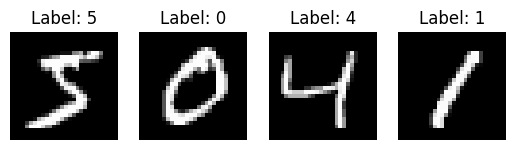

In [9]:
for i in range(4):
    plt.subplot(2, 4, i + 1) # This is used to plot multiple things in a single figure
    plt.axis('off') # Removes axis
    plt.imshow(data_tr[i, :].reshape((28, 28)), cmap=plt.cm.gray, interpolation='nearest')
    plt.title('Label: %i' % labels_tr[i])

## Setting up training

While we have already a training and a test split, if this were a real project we would also need a **validation** split. Therefore, we create it by taking some of the training subset and using that for validation.

In [10]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(data_tr, labels_tr, test_size=0.2)

print('Training data and target sizes: \n{}, {}'.format(X_tr.shape, y_tr.shape))
print('Test data and target sizes: \n{}, {}'.format(X_val.shape, y_val.shape))

Training data and target sizes: 
(48000, 784), (48000,)
Test data and target sizes: 
(12000, 784), (12000,)


## Finally, training!

In this final section of the first lab, we will train and evaluate a few common algorithms for classification. We will choose the best one based on its performance on the validation set, and we will save it for the next lab sessions.

We will be using the implementations of those algorithms provided by the `scikit-learn` package, which emerged as a standard a few years ago. This means that you don't have to implement those algorithms by yourself, and can focus on the experimentation bits.

You will see that algorithms in this package have all the same interface, and require the same steps to train a model.

1. Instantiate the classifier object (each algorithm will likely have different options to choose from, the default ones are fine for this).
2. Call the `.fit()` method passing as parameters the features and the labels of the training set.

Note that we are cutting quite a lot of corners here, and in reality we would do a few more things such as considering using a K-fold cross validation, doing proper hyperparameter optimization, but it's kind of beyond the scope of this lab. Just remember that this is a toy project!

The first classifier will be the **[Decision tree](https://en.wikipedia.org/wiki/Decision_tree)**

In [11]:
from sklearn import tree

class_tree=tree.DecisionTreeClassifier()
class_tree.fit(X_tr, y_tr)

DecisionTreeClassifier()

Now we have a trained model. In order to determine whether it's any good, we need to evaluate its performance by having it classify the samples from the validation set, which (and this is _very_ important) we **haven't used during the training**.

Since this is a classification problem where all classes have (roughly) the same number of samples, we can rely on the **accuracy score** (i.e. the ratio of correctly classified samples) for that.
If classes were _unbalanced_, we would need to use something a bit different.

In [12]:
from sklearn.metrics import accuracy_score

y_pred = class_tree.predict(X_val)
print("Accuracy of model class_tree = %2f%%" % (accuracy_score(y_val, y_pred )*100))

Accuracy of model class_tree = 86.666667%


Around 86.8% without any parametrers tunning. Not bad, but let's test the accuracy of a ** [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)**

In [13]:
from sklearn.linear_model import LogisticRegression

### TODO ###
# Train a classifier which uses Logistic Regression and print its accuracy


class_lr = LogisticRegression()
class_lr.fit(X_tr, y_tr)
y_pred = class_lr.predict(X_val)

print("Accuracy of model class_lr = %2f%%" % (accuracy_score(y_val, y_pred )*100))

### END ###

Accuracy of model class_lr = 91.608333%


C:\Users\neopa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\Local\pypoetry\Cache\virtualenvs\phd-school-PN9knR8Y-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression should be a little better than the Tree classifier. Lets try  **[Neural Network](https://en.wikipedia.org/wiki/Artificial_neural_network)**

Check **[scikit-learn Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)**

In this classifier, the input data is normalized.  In theory, it's not necessary to normalize numeric x-data (also called independent data). However, practice has shown that when numeric x-data values are normalized, neural network training is often more efficient, which leads to a better predictor.

Notice that the scaler object uses only the features, without the labels. It also has a `fit` method, but instead of `predict` we use the `transform`, to apply the same transformation to the features of both the training and the validation subsets.

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier())])

#input data normalization
scaler = StandardScaler()
scaler.fit(X_tr)

X_tr_scaled=scaler.transform(X_tr)
X_val_scaled=scaler.transform(X_val)

### TODO ###
# Train a classifier which uses the MLPClassifier and print its accuracy
# WARNING: use the scaled features both when training and when testing the model

mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_tr_scaled, y_tr)
y_pred = mlp_classifier.predict(X_val_scaled)

print("Accuracy of model MLPClassifier = %2f%%" % (accuracy_score(y_val, y_pred )*100))

### END ###

Accuracy of model MLPClassifier = 97.233333%


In [16]:
# It's actually useful to pack both the preprocessing and the actual training process in a single Pipeline object,
# so that it can be used on the raw data directly, streamlining the process.

from sklearn.pipeline import Pipeline

# This just means that the pipeline takes care of making both steps in the right way.
pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier())])

pipeline.fit(X_tr, y_tr)
y_pred = pipeline.predict(X_val)

print("Accuracy of model MLPClassifier = %2f%%" % (accuracy_score(y_val, y_pred )*100))

Accuracy of model MLPClassifier = 97.383333%


You should be getting an even better classifier!  Now, we gonna try the **[Multinomial naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes)**  classifier.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
 
### TODO ###
# Train a classifier which uses MultinomialNB and print its accuracy

### END ###

Let's try the **[K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)** classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### TODO ###
# Train a classifier which uses KNeighborsClassifier and print its accuracy

### END ###

This should also be pretty good!

Now pick whatever model achieves the highest accuracy and assign it to a variable called `best_model`.

For instance, if your best model were the first one we played around with, i.e. the decision tree (it really shouldn't), you would write this in the following cell:

```Python
best_model = class_tree
```

In [17]:
# Declare your winner!

best_model = pipeline

In [18]:
from sklearn.metrics import  classification_report

# We overwrite `y_pred` to make sure that it refers to the results of the best model.

y_pred = best_model.predict(X_val)

print("Classification report for classifier %s:\n%s\n"
      % (best_model, classification_report(y_val, y_pred)))

Classification report for classifier Pipeline(steps=[('scaler', StandardScaler()), ('mlp', MLPClassifier())]):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1158
           1       0.99      0.99      0.99      1360
           2       0.96      0.97      0.97      1151
           3       0.97      0.96      0.97      1208
           4       0.97      0.97      0.97      1151
           5       0.97      0.96      0.96      1112
           6       0.98      0.98      0.98      1189
           7       0.97      0.98      0.97      1247
           8       0.97      0.96      0.97      1173
           9       0.97      0.97      0.97      1251

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000




**What does it mean?**
precision: is a fraction of relevant instance among the retrieved instances and is defined as: 

 

precision=tp / (tp + fp) 

 

recall: is the fraction of relevant instances that have been retrieved over total relevant instances in the image, and is defined as 

 

Recall= tp / (tp + fn) 

 

tp= true positives 

fp= false positives 

fn= false negatives 

 

 

 

f1-score: a mesure of accuracy. Considers precision and recall and the general formula is: 

 

F1-score= 2 X (precision X recall) / (precision + recall) 

 

References:  https://en.wikipedia.org/wiki/Precision_and_recall 

https://en.wikipedia.org/wiki/F1_score 




And, to complete our analysis, let's see the confusion matrix. The right predictions are in the main diagonal. For every value on the diagonal, the **numbers in the same line** are the **false positives** 
And those in the **same column** are the **false negatives** 

https://en.wikipedia.org/wiki/Confusion_matrix 


In [19]:
from sklearn.metrics import confusion_matrix

print("Confusion matrix:\n%s" % confusion_matrix(y_val, y_pred))

Confusion matrix:
[[1141    0    2    2    1    4    4    2    1    1]
 [   0 1343    5    3    3    0    1    3    2    0]
 [   1    2 1117    7    5    0    3    5   10    1]
 [   1    2   16 1161    0   11    0    6    3    8]
 [   1    3    3    0 1120    2    4    6    0   12]
 [   4    1    1    6    4 1072    7    4    5    8]
 [   5    0    1    0    3    9 1169    0    2    0]
 [   0    2    8    1    4    0    0 1222    2    8]
 [   7    4    3   13    2    5    5    2 1129    3]
 [   1    1    2    0   11    7    0   12    5 1212]]


But wait! Data science is also about a good presentation of results. Let's improve our Confusion Matrix Visualization

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.rcParams['figure.figsize'] = (12,8) # set the plot size
    plt.rcParams['font.size']= (16)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()

Confusion matrix, without normalization


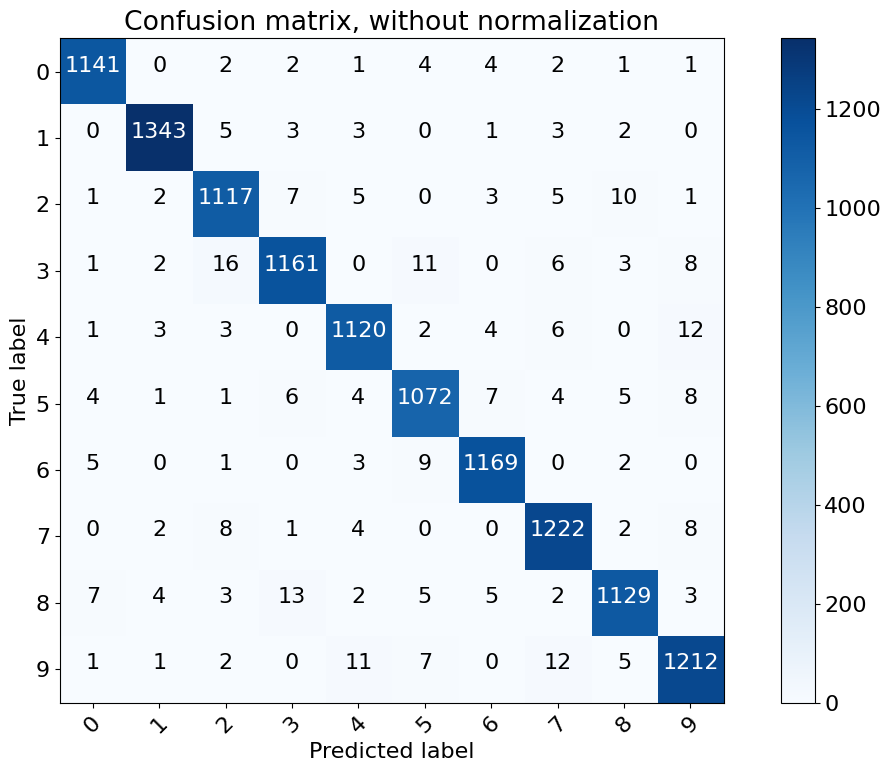

In [21]:
target_names=[i for i in range(10)]
cnf_matrix=confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.show()

Well, we already have our model, how can we save it for further use?
Pickle is the answer. 

In [22]:
import pickle

# Use pickle to save model for next usage.

# Create folder if it does not exist
Path(ARTIFACTS_DIR).mkdir(exist_ok=True)

best_model_path = Path(ARTIFACTS_DIR) / 'best_model_sklearn.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f) 